## 1. Import Required Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import io, color
from PIL import Image
import requests
from io import BytesIO

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Sample Image

We'll use a sample image from the internet for demonstration. You can also replace this with your own image path.

Using built-in coffee image. Shape: (400, 600, 3)


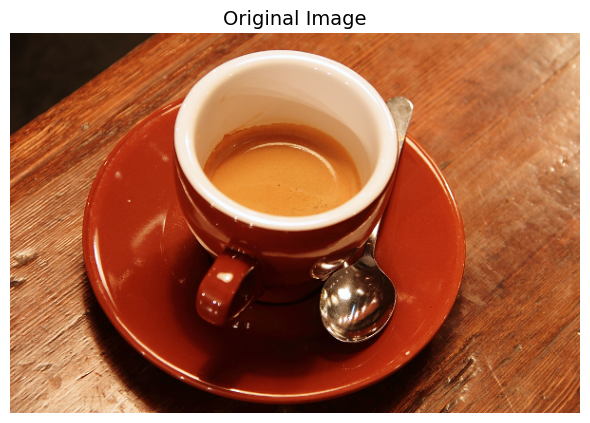

In [2]:
# Load a sample image from URL (you can replace with local path)
url = "https://raw.githubusercontent.com/scikit-image/scikit-image/main/skimage/data/coffee.png"

try:
    response = requests.get(url)
    image = np.array(Image.open(BytesIO(response.content)))
    print(f"Image loaded successfully! Shape: {image.shape}")
except:
    # Fallback: Load from skimage dataset
    from skimage import data
    image = data.coffee()
    print(f"Using built-in coffee image. Shape: {image.shape}")

# Display original image
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.title('Original Image', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

## 3. Preprocess Image for K-Means

We need to reshape the image from (height, width, channels) to (pixels, channels) format for K-means clustering.

In [3]:
# Store original shape for later reconstruction
original_shape = image.shape
print(f"Original image shape: {original_shape}")

# Reshape image to be a list of pixels
# From (height, width, channels) to (height*width, channels)
pixels = image.reshape(-1, 3)
print(f"Reshaped to: {pixels.shape}")
print(f"Total pixels: {pixels.shape[0]:,}")

# Convert to float for better precision
pixels = np.float32(pixels)

Original image shape: (400, 600, 3)
Reshaped to: (240000, 3)
Total pixels: 240,000


## 4. K-Means Segmentation Function

Create a function to perform K-means clustering on the image.

In [4]:
def segment_image_kmeans(pixels, original_shape, k, random_state=42):
    """
    Segment image using K-means clustering.
    
    Parameters:
    - pixels: flattened pixel array
    - original_shape: original image shape for reconstruction
    - k: number of clusters
    - random_state: random seed for reproducibility
    
    Returns:
    - segmented_image: image with pixels replaced by cluster centers
    """
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    kmeans.fit(pixels)
    
    # Get cluster labels for each pixel
    labels = kmeans.labels_
    
    # Get cluster centers (representative colors)
    centers = kmeans.cluster_centers_
    
    # Replace each pixel with its cluster center
    segmented = centers[labels]
    
    # Reshape back to original image shape
    segmented_image = segmented.reshape(original_shape)
    
    # Convert back to uint8
    segmented_image = np.uint8(segmented_image)
    
    return segmented_image, kmeans

print("Segmentation function defined!")

Segmentation function defined!


## 5. Perform Segmentation with Different K Values

Let's segment the image with K = 2, 3, and 10 to see the effect.

In [10]:
# Define K values to test
k_values = [2, 3, 5, 10]

# Store segmented images
segmented_images = {}
kmeans_models = {}

# Perform segmentation for each K value
for k in k_values:
    print(f"Processing K = {k}...")
    seg_img, model = segment_image_kmeans(pixels, original_shape, k)
    segmented_images[k] = seg_img
    kmeans_models[k] = model
    print(f"  Completed! Inertia: {model.inertia_:.2f}")

print("\nAll segmentations complete!")

Processing K = 2...
  Completed! Inertia: 1103292672.00
Processing K = 3...
  Completed! Inertia: 1103292672.00
Processing K = 3...
  Completed! Inertia: 524438144.00
Processing K = 5...
  Completed! Inertia: 524438144.00
Processing K = 5...
  Completed! Inertia: 206110480.00
Processing K = 10...
  Completed! Inertia: 206110480.00
Processing K = 10...
  Completed! Inertia: 82289288.00

All segmentations complete!
  Completed! Inertia: 82289288.00

All segmentations complete!


## 6. Visualize Results

Display all segmented images alongside the original image.

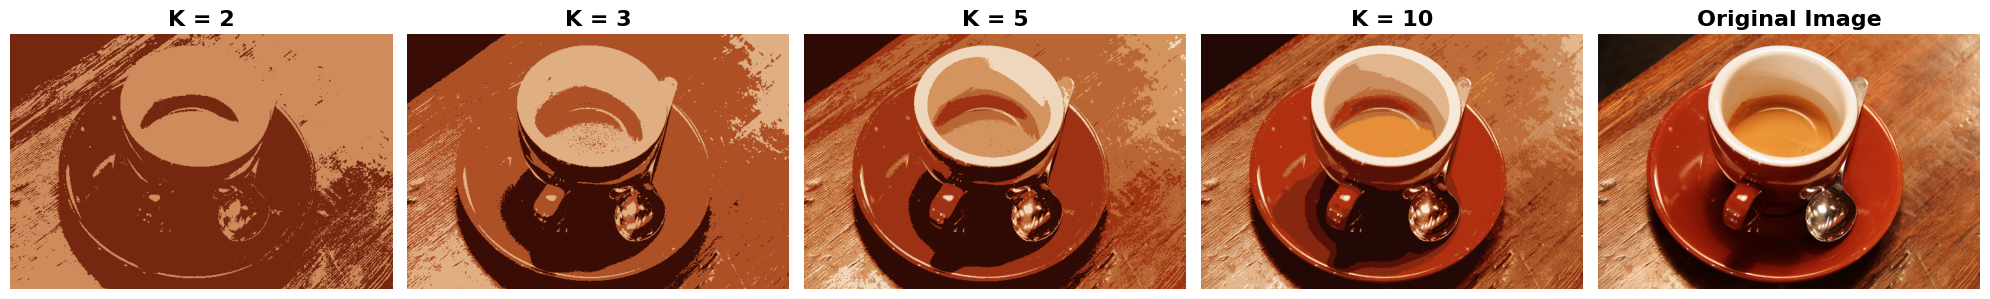

In [11]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

# Plot segmented images
for idx, k in enumerate(k_values):
    axes[idx].imshow(segmented_images[k])
    axes[idx].set_title(f'K = {k}', fontsize=16, fontweight='bold')
    axes[idx].axis('off')

# Plot original image
axes[4].imshow(image)
axes[4].set_title('Original Image', fontsize=16, fontweight='bold')
axes[4].axis('off')

plt.tight_layout()
plt.show()

## 7. Analyze Cluster Centers (Dominant Colors)

Let's visualize the dominant colors found by K-means for each K value.

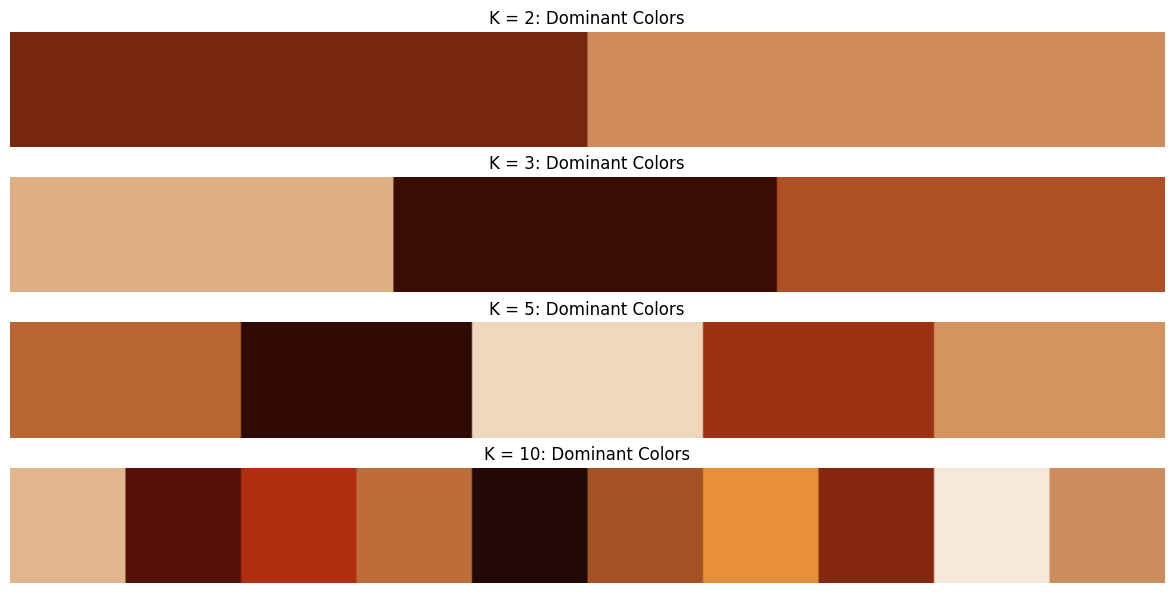

In [12]:
fig, axes = plt.subplots(len(k_values), 1, figsize=(12, 6))

for idx, k in enumerate(k_values):
    # Get cluster centers
    centers = kmeans_models[k].cluster_centers_
    
    # Create a color palette from cluster centers
    palette = np.uint8(centers)
    
    # Create an image showing the colors
    color_bar = np.zeros((50, 500, 3), dtype=np.uint8)
    width_per_color = 500 // k
    
    for i in range(k):
        start = i * width_per_color
        end = (i + 1) * width_per_color if i < k - 1 else 500
        color_bar[:, start:end] = palette[i]
    
    axes[idx].imshow(color_bar)
    axes[idx].set_title(f'K = {k}: Dominant Colors', fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

## 8. Performance Metrics

Compare the performance metrics (inertia) for different K values.

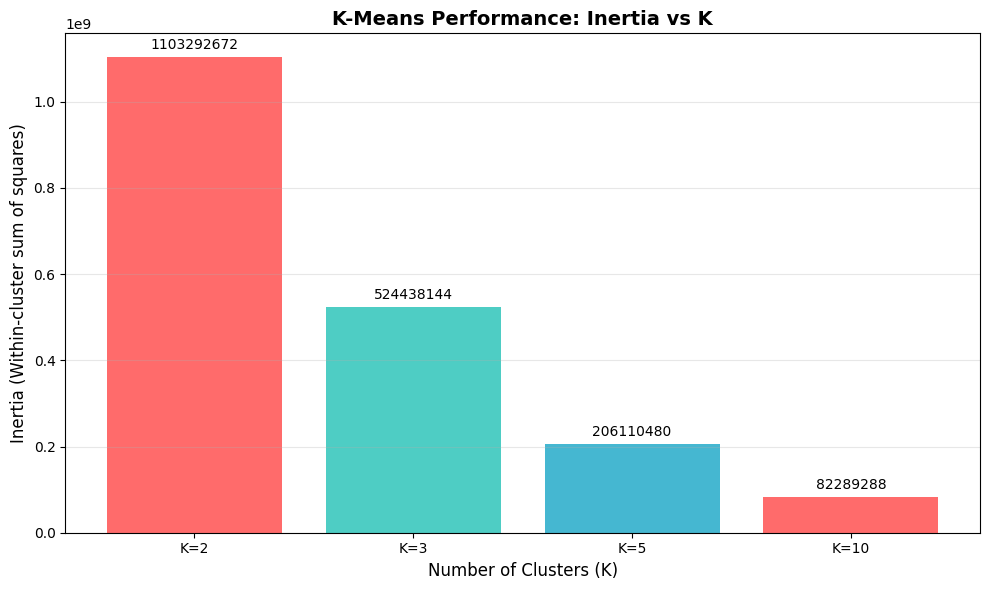


Performance Summary:
K =  2 | Inertia: 1,103,292,672.00
K =  3 | Inertia: 524,438,144.00
K =  5 | Inertia: 206,110,480.00
K = 10 | Inertia: 82,289,288.00


In [13]:
# Extract inertia values
inertias = [kmeans_models[k].inertia_ for k in k_values]

# Create bar plot
plt.figure(figsize=(10, 6))
plt.bar([f'K={k}' for k in k_values], inertias, color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('K-Means Performance: Inertia vs K', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(inertias):
    plt.text(i, v + max(inertias)*0.01, f'{v:.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Print summary
print("\nPerformance Summary:")
print("=" * 40)
for k in k_values:
    print(f"K = {k:2d} | Inertia: {kmeans_models[k].inertia_:,.2f}")

## 9. Optional: Use Your Own Image

Uncomment and modify the code below to segment your own image.

In [14]:
# Uncomment and modify the path to use your own image
# custom_image_path = "path/to/your/image.jpg"
# custom_image = io.imread(custom_image_path)
# custom_pixels = custom_image.reshape(-1, 3).astype(np.float32)
# custom_shape = custom_image.shape

# # Segment with K=10
# custom_segmented, _ = segment_image_kmeans(custom_pixels, custom_shape, k=10)

# # Display
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# axes[0].imshow(custom_image)
# axes[0].set_title('Original')
# axes[0].axis('off')
# axes[1].imshow(custom_segmented)
# axes[1].set_title('Segmented (K=10)')
# axes[1].axis('off')
# plt.tight_layout()
# plt.show()

print("To use your own image, uncomment the code above and provide the image path.")

To use your own image, uncomment the code above and provide the image path.


## Summary

**Key Observations:**

- **K = 2**: Very simple segmentation with only 2 colors, loses most detail
- **K = 3**: Better segmentation with 3 dominant colors, maintains some structure
- **K = 10**: Much more detailed segmentation, closer to the original image

**How K-Means Works for Image Segmentation:**
1. Each pixel is treated as a point in 3D space (RGB values)
2. K-means finds K cluster centers (dominant colors)
3. Each pixel is assigned to the nearest cluster center
4. All pixels in a cluster are colored with the cluster center color

**Trade-offs:**
- Lower K: Faster computation, simpler representation, artistic effect
- Higher K: More detail, closer to original, but more computation time